# Aprendizaje Automático en Series Temporales - Análisis de la temperatura media diaria de Madrid


# Imports de librerías necesarias

In [ ]:
pip install skforecast

In [ ]:
pip install meteostat

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot, autocorrelation_plot
import seaborn as sns
from meteostat import Daily, Stations
from datetime import datetime
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings


#estilo de graficos
plt.rcParams['figure.figsize'] = (9, 4)
pd.options.display.float_format = '{:,.4f}'.format

#mostrar versiones
try:
    import skforecast
    print('skforecast:', skforecast.__version__)
except Exception as e:
    print('skforecast no disponible:', e)
try:
    import sklearn
    print('scikit-learn:', sklearn.__version__)
except Exception as e:
    print('sklearn no disponible:', e)


skforecast: 0.18.0
scikit-learn: 1.6.1


# Análisis exploratorio de los datos

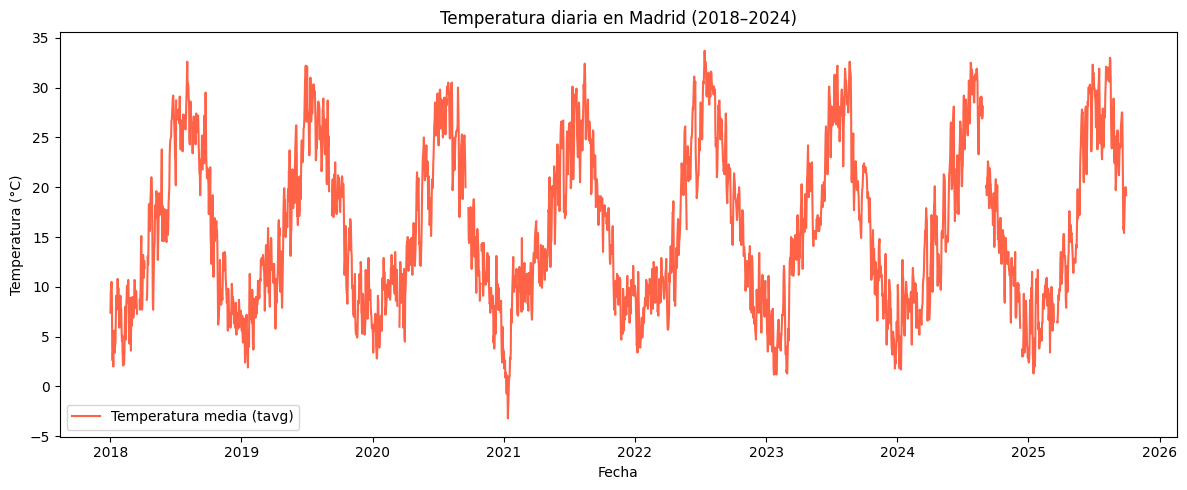

              tavg   tmin    tmax
time                             
2018-01-01  7.4000 3.6000 11.6000
2018-01-02  9.5000 7.5000 13.4000
2018-01-03  9.9000 7.6000 13.5000
2018-01-04 10.5000 7.8000 13.7000
2018-01-05  9.3000 5.8000 11.5000


In [ ]:
#estación cerca de madrid
stations = Stations()
station = stations.nearby(40.4168, -3.7038).fetch(1)
station_id = station.index[0]

#fechas
start = datetime(2018, 1, 1)
end = datetime(2025, 9, 30)

#datos diarios
data = Daily(station_id, start, end)
df = data.fetch()

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['tavg'], color='tomato', label='Temperatura media (tavg)')
#plt.plot(df.index, df['tmin'], color='skyblue', alpha=0.5, label='Temperatura mínima (tmin)')
#plt.plot(df.index, df['tmax'], color='orange', alpha=0.5, label='Temperatura máxima (tmax)')
plt.title('Temperatura diaria en Madrid (2018–2024)')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.tight_layout()
plt.show()

print(df[['tavg', 'tmin', 'tmax']].head())

In [ ]:
#variables disponibles
df.columns

Index(['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun'],
      dtype='object')

In [ ]:
df.shape

(2830, 10)

In [ ]:
df.describe()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,"2,773.0000","2,830.0000","2,830.0000","2,823.0000",0.0000,0.0000,"1,712.0000",0.0000,"1,712.0000",0.0000
mean,15.8668,11.3427,21.4254,1.3756,<NA>,<NA>,11.1305,<NA>,"1,017.9054",<NA>
std,8.0129,6.7784,9.0718,4.6834,<NA>,<NA>,4.3220,<NA>,6.4555,<NA>
min,-3.2000,-7.4000,0.3000,0.0000,<NA>,<NA>,3.5000,<NA>,994.1000,<NA>
25%,9.3000,5.7000,13.5000,0.0000,<NA>,<NA>,7.9000,<NA>,"1,013.8750",<NA>
50%,14.5000,10.4000,19.9500,0.0000,<NA>,<NA>,10.6000,<NA>,"1,017.1500",<NA>
75%,22.4000,16.8000,29.1750,0.1000,<NA>,<NA>,13.3000,<NA>,"1,021.5000",<NA>
max,33.7000,26.2000,40.7000,71.5000,<NA>,<NA>,31.0000,<NA>,"1,039.1000",<NA>


In [ ]:
#eliminamos variables con valores nulos
df = df.drop(columns=['snow','wdir','wpgt','tsun'],axis=1)

## Resample semanal con first y mean

Número de filas después del resample semanal: 405


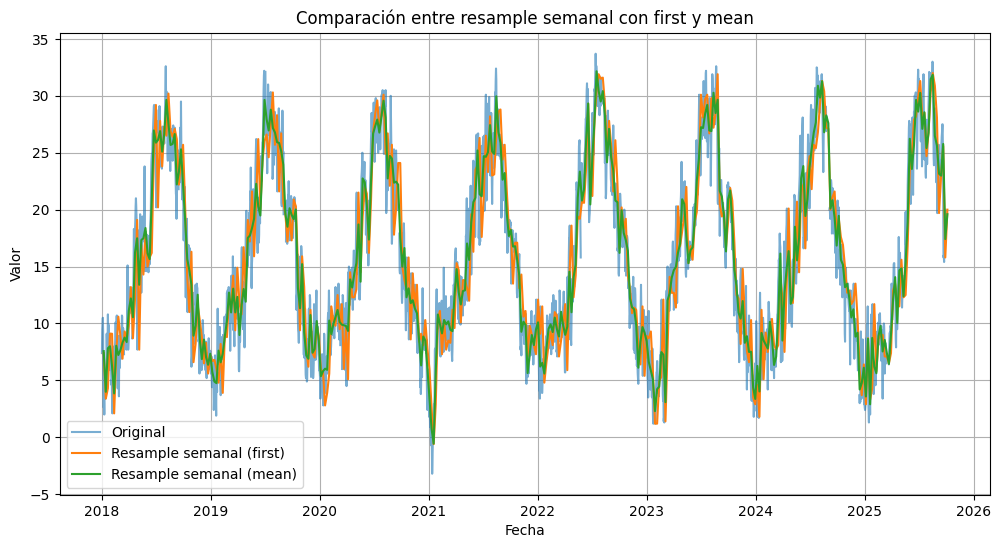

In [ ]:
#resampleo semanal (primer valor de cada semana)
df_week_first = df[['tavg']].resample('W').first()

# Resampleo semanal (promedio de cada semana)
df_week_mean = df[['tavg']].resample('W').mean()

print("Número de filas después del resample semanal:", len(df_week_mean))


plt.figure(figsize=(12, 6))
plt.plot(df.index, df[['tavg']], label='Original', alpha=0.6)
plt.plot(df_week_first.index, df_week_first, label='Resample semanal (first)')
plt.plot(df_week_mean.index, df_week_mean, label='Resample semanal (mean)')
plt.title('Comparación entre resample semanal con first y mean')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

## Imputación de valores nulos

Número de outliers detectados: 0 (factor=1)
Límites inferior/superior: -4.00, 35.60


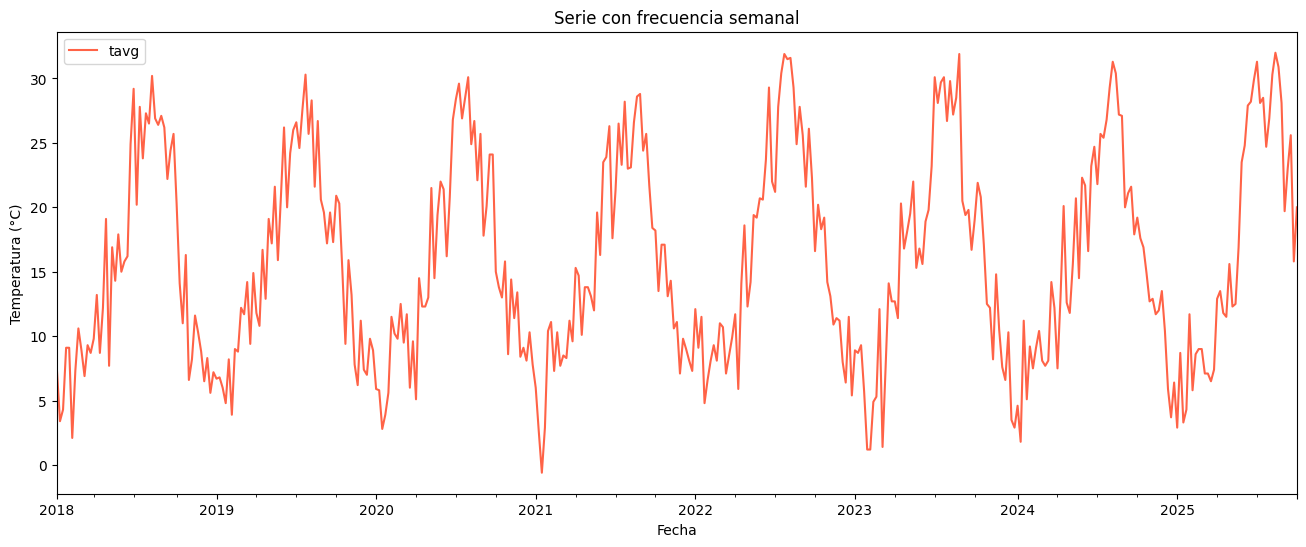

In [ ]:
#imputación sencilla
#    ffill: rellena con el último valor conocido
#    bfill: rellena hacia adelante lo que no cubra ffill
df = df.ffill().bfill()
df = df.dropna()

# detección de atípicos (IQR)
factor =
q1 = df['tavg'].quantile(0.25)
q3 = df['tavg'].quantile(0.75)
iqr = q3 - q1
lim_inf = q1 - factor * iqr
lim_sup = q3 + factor * iqr

outliers = df[(df['tavg'] < lim_inf) | (df['tavg'] > lim_sup)]

print(f"Número de outliers detectados: {len(outliers)} (factor={factor})")
print(f"Límites inferior/superior: {lim_inf:.2f}, {lim_sup:.2f}")

df_week_first[['tavg']].plot(title='Serie con frecuencia semanal', figsize=(16, 6), color='tomato')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.show()

In [ ]:
#verifiación final de nulos
print(df.isna().sum())

tavg    0
tmin    0
tmax    0
prcp    0
wspd    0
pres    0
dtype: int64


## Reseteo del índice para asegurar orden cronológico

In [ ]:
# ordenamos el índice por si acaso
df = df.sort_index()

# Ingeniería de lags

,tavg,tavg_lag1,tavg_lag2,tavg_lag3,tavg_lag4,tavg_lag5,tavg_lag6,tavg_lag7,tavg_lag8,tavg_lag9,tavg_lag10
time,,,,,,,,,,,
2025-08-03,26.9000,24.7000,28.5000,28.1000,31.3000,29.9000,28.2000,27.9000,24.8000,23.5000,16.9000
2025-08-10,30.3000,26.9000,24.7000,28.5000,28.1000,31.3000,29.9000,28.2000,27.9000,24.8000,23.5000
2025-08-17,32.0000,30.3000,26.9000,24.7000,28.5000,28.1000,31.3000,29.9000,28.2000,27.9000,24.8000
2025-08-24,30.9000,32.0000,30.3000,26.9000,24.7000,28.5000,28.1000,31.3000,29.9000,28.2000,27.9000
2025-08-31,28.1000,30.9000,32.0000,30.3000,26.9000,24.7000,28.5000,28.1000,31.3000,29.9000,28.2000
2025-09-07,19.7000,28.1000,30.9000,32.0000,30.3000,26.9000,24.7000,28.5000,28.1000,31.3000,29.9000
2025-09-14,23.0000,19.7000,28.1000,30.9000,32.0000,30.3000,26.9000,24.7000,28.5000,28.1000,31.3000
2025-09-21,25.6000,23.0000,19.7000,28.1000,30.9000,32.0000,30.3000,26.9000,24.7000,28.5000,28.1000
2025-09-28,15.8000,25.6000,23.0000,19.7000,28.1000,30.9000,32.0000,30.3000,26.9000,24.7000,28.5000


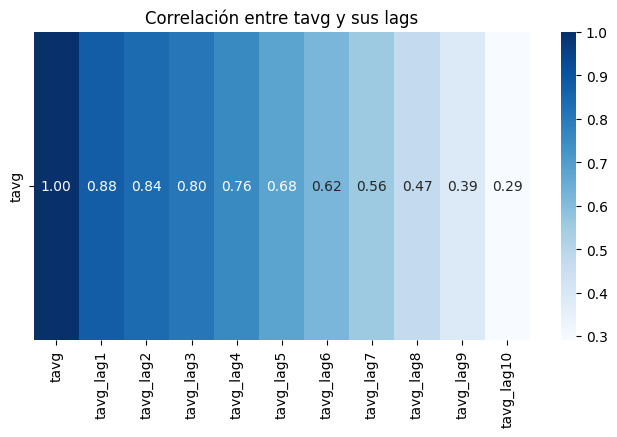

In [ ]:
# función para generar lags
def generar_atributos_desfase(ts_data, var, max_lag):
    """
    Crea columnas var_lag1, var_lag2, ..., var_lag{k} con shift(t).
    ts_data: DataFrame con índice temporal
    var:     nombre de la columna base (p.ej., 'Nivel')
    max_lag: número máximo de retardos
    """
    for t in range(1, max_lag + 1):
        ts_data[f'{var}_lag{t}'] = ts_data[var].shift(t)
    return ts_data

#10 lags
df_lags = generar_atributos_desfase(df_week_first, 'tavg', max_lag=10)

display(df_lags.tail(10))

#correlación de cada lag con la variable original
lags_cols = [c for c in df_lags.columns if c.startswith('tavg_lag')]
corr = df_lags[['tavg'] + lags_cols].dropna().corr()['tavg'].sort_values(ascending=False)
corr
#mapa de calor
plt.figure(figsize=(8, 4))
sns.heatmap(
    df_lags[['tavg'] + lags_cols].dropna().corr()[['tavg']].T,
    annot=True, cmap='Blues', fmt=".2f"
)
plt.title('Correlación entre tavg y sus lags')
plt.show()

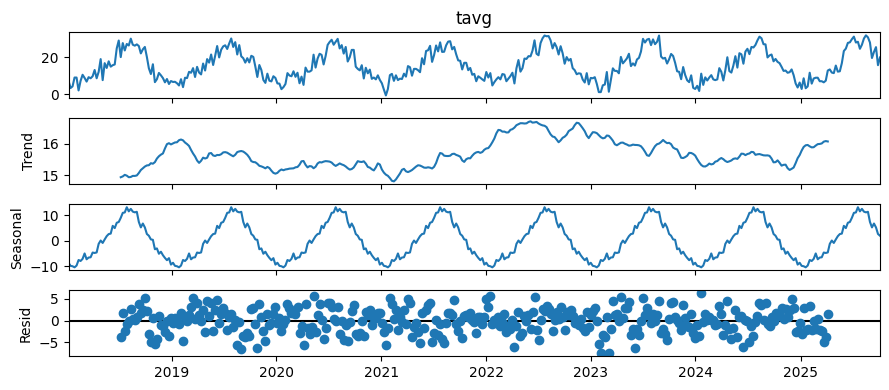

In [ ]:
# Descomposición estacional simple
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_week_first['tavg'], model='additive', period=52)
decomp.plot();

En esta gráfica podemos ver la descomposición de la temperatura media de nuestra serie temporal de la temperatura media ("tavg") desde 2018 hasta 2025, separando los datos originales en sus tres componentes fundamentales.

En el  segundo panel podemos observar la tendencia la cual revela la dirección general a largo plazo de la temperatura. De esta podemos sacar en claro que más allá de las fluctuaciones diarias, la temperatura media subyacente ha experimentado cambios, como un notable calentamiento entre 2021 y 2023.

En el tercer panel podemos ver la estacionalidad donde se aísla el patrón cíclico y repetitivo que corresponde claramente a las estaciones del año, con picos regulares en verano y valles en invierno.

Por último, podemos observar el residuo, el cual muestra el "ruido" o las variaciones aleatorias que no pueden ser explicadas ni por la tendencia ni por la estacionalidad.

Las conclusiones clave que podemos sacar son:
* La serie está abrumadoramente dominada por un fuerte y regular patrón estacional, que corresponde al ciclo anual de temperaturas y explica la mayor parte de sus fluctuaciones
* La tendencia a largo plazo no es plana ya que podemos observar un cambio subyacente significativo, mostrando que la temperatura base aumentó gradualmente desde 2018 hasta alcanzar un pico notable alrededor de 2022-2023
* La subgráfica de residuos nos muestra un comportamiento aleatorio sin patrones claros, lo que es una buena señal, pues indica que el modelo ha capturado con éxito las estructuras principales (tendencia y estacionalidad) y que lo restante es ruido impredecible.

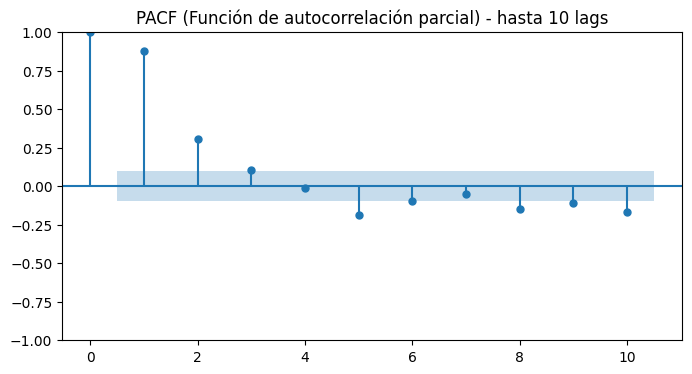

In [ ]:
# PACF exploratorio
fig, ax = plt.subplots(figsize=(8,4))
plot_pacf(df_week_first['tavg'].dropna(), lags=10, ax=ax, method='ywm')
plt.title('PACF (Función de autocorrelación parcial) - hasta 10 lags')
plt.show()

En esta gráfico se muestra el PACF, mediante la cual somos capaces de medir la correlación directa entre el valor actual de una serie y sus valores pasados (lags), eliminando la influencia de los rezagos intermedios.

En la gráfica, la banda azul representa el intervalo de confianza, por lo que cualquier pico que sobresalga de ella, como es el caso de los primeros lags los cual nos indica una correlación estadísticamente significativa.

La conclusión principal se extrae del patrón de "corte abrupto" que ocurre después del lag 3, donde todos los picos siguientes caen dentro de la banda y se vuelven no significativos. Este comportamiento es la señal característica de un proceso Autorregresivo (AR), y sugiere que el valor actual de la serie depende directamente de sus tres valores pasados, por lo que el modelo de pronóstico más adecuado sería un AR(3).

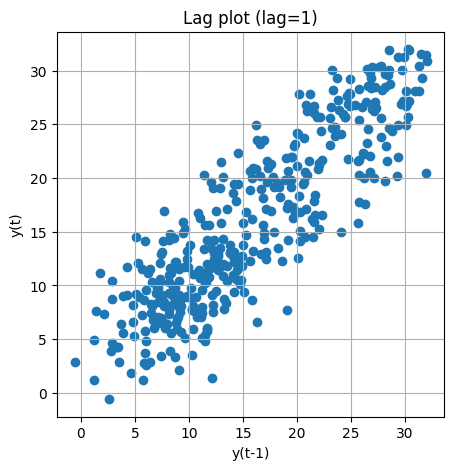

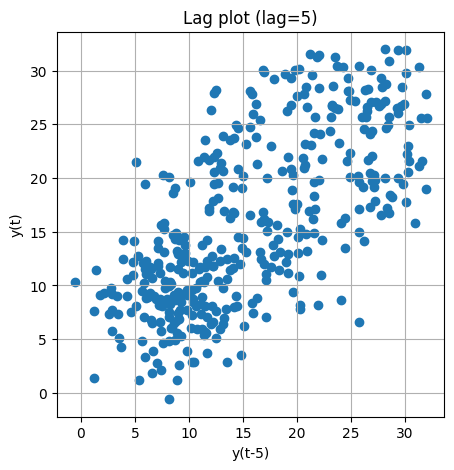

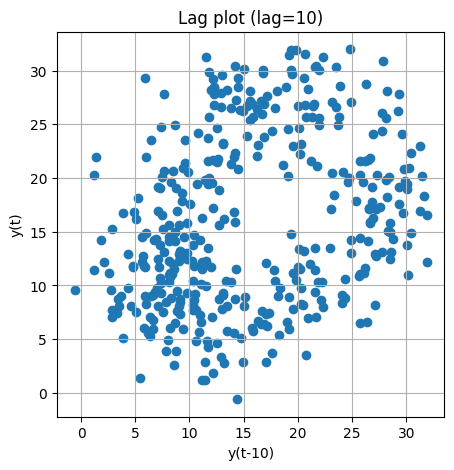

In [ ]:
for lag in [1, 5, 10]:
    plt.figure(figsize=(5,5))
    lag_plot(df_week_first['tavg'], lag=lag)
    plt.title(f"Lag plot (lag={lag})")
    plt.xlabel(f"y(t-{lag})"); plt.ylabel("y(t)"); plt.grid(True); plt.show()

Como fue remarcado anteriormente, se puede observar una alta correlación con el primer lag, para luego ir decayendo gradualmente. Se puede observar que la correlación con el lag 10 ya es muy débil, basta con interpretar el gráfico correspondiente, que muestra una nube de puntos sin tendencia evidente.

# Modelos autorregresivos

## Modelo AR

[AR(52)] MAE=2.127  RMSE=2.592


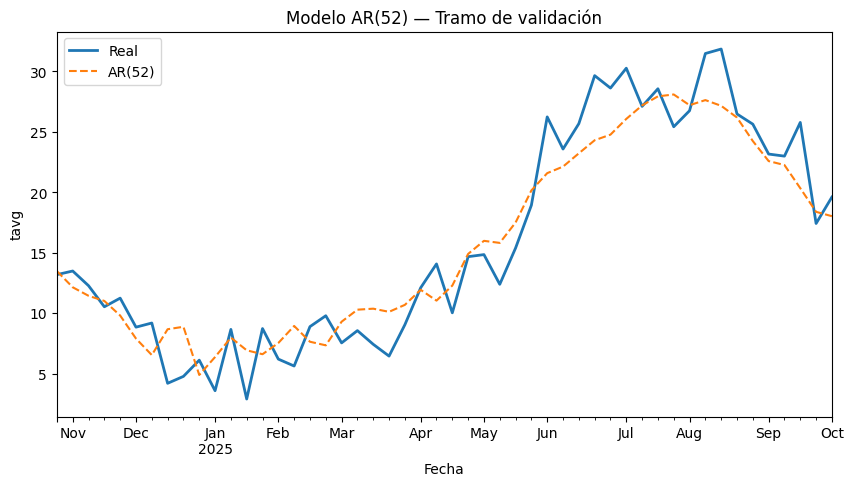

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

# serie y split
y = df_week_mean['tavg']
H = 50  #tramo de validación
H = int(min(H, len(y) - 5))
y_train = y.iloc[:-H].copy()
y_valid = y.iloc[-H:].copy()

# modelo AR
p = 52  # número de rezagos
modelo_ar = AutoReg(y_train, lags=52, old_names=False)
res_ar = modelo_ar.fit()

#predicción
pred_ar = res_ar.predict(start=y_valid.index[0], end=y_valid.index[-1])

# métricas
MAE_ar = mean_absolute_error(y_valid, pred_ar)
RMSE_ar = np.sqrt(mean_squared_error(y_valid, pred_ar))
print(f"[AR({p})] MAE={MAE_ar:.3f}  RMSE={RMSE_ar:.3f}")

plt.figure(figsize=(10,5))
y_valid.plot(label='Real', linewidth=2)
pred_ar.plot(label=f'AR({p})', linestyle='--')
plt.title(f'Modelo AR({p}) — Tramo de validación')
plt.xlabel('Fecha')
plt.ylabel('tavg')
plt.legend()
plt.show()

In [ ]:
len(y_train)

355

In [ ]:
len(y_valid)

50

## Variables exógenas


In [ ]:
# resampleamos de nuevo a formato semanal pero ahora con todas las variables exógenas
df_week_mean = df.resample('W').mean()
df_week_mean.tail()

,tavg,tmin,tmax,prcp,wspd,pres
time,,,,,,
2025-09-07,23.1571,17.0000,29.3286,0.0000,11.8000,"1,015.9857"
2025-09-14,22.9857,16.7143,28.8857,0.0857,10.4857,"1,017.2857"
2025-09-21,25.7714,19.1143,32.3429,0.2714,8.6571,"1,019.5000"
2025-09-28,17.4143,10.9571,23.2429,0.0000,9.0286,"1,018.3857"
2025-10-05,19.6000,15.3500,24.2000,0.0000,12.1000,"1,018.1000"


In [ ]:
# alinear índices
exog = df_week_mean.drop(columns=['tavg','tmin','tmax'])
exog = exog.loc[y.index]  # asegurar mismo índice temporal

# mantener solo columnas numéricas y convertir a float
exog = exog.select_dtypes(include=[np.number]).astype(float)

exog = exog.ffill().bfill()

# lags del 1 al 5 para cada columna
lags = 5
exog_lags = pd.concat(
    [exog.shift(i).add_suffix(f"_lag{i}") for i in range(1, lags + 1)],
    axis=1
)

exog_lags = exog_lags.dropna()

# Alinear y ajustar la variable objetivo al nuevo índice
y = y.loc[exog_lags.index]

print(exog_lags.dtypes)
print(exog_lags.shape, y.shape)
print(y.index.equals(exog_lags.index))


prcp_lag1    float64
wspd_lag1    float64
pres_lag1    float64
prcp_lag2    float64
wspd_lag2    float64
pres_lag2    float64
prcp_lag3    float64
wspd_lag3    float64
pres_lag3    float64
prcp_lag4    float64
wspd_lag4    float64
pres_lag4    float64
prcp_lag5    float64
wspd_lag5    float64
pres_lag5    float64
dtype: object
(400, 15) (400,)
True


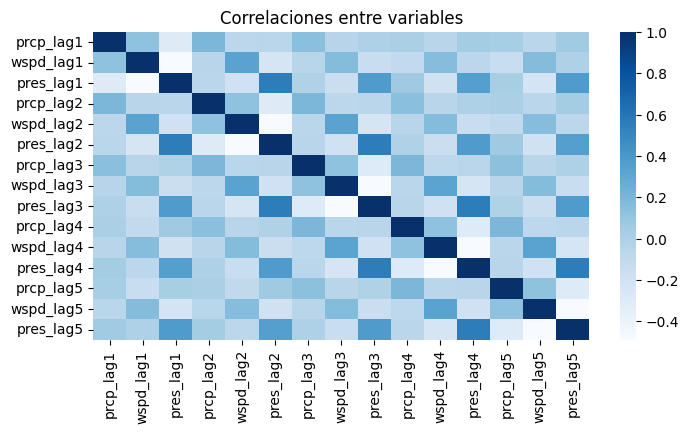

In [ ]:
# Correlación de cada lag con la variable original
plt.figure(figsize=(8, 4))
sns.heatmap(
    exog_lags.corr(),
    annot=False, cmap='Blues', fmt=".2f"
)
plt.title('Correlaciones entre variables')
plt.show()

## Modelos ARIMA

In [ ]:
HORIZON = 50

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

### Modelo sin variables exógenas

                               SARIMAX Results                                
Dep. Variable:                   tavg   No. Observations:                  400
Model:                ARIMA(36, 1, 1)   Log Likelihood                -879.388
Date:                Thu, 23 Oct 2025   AIC                           1834.776
Time:                        16:03:18   BIC                           1986.357
Sample:                    02-11-2018   HQIC                          1894.810
                         - 10-05-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4898      0.049      9.995      0.000       0.394       0.586
ar.L2         -0.0054      0.060     -0.089      0.929      -0.123       0.113
ar.L3          0.0911      0.056      1.623      0.1

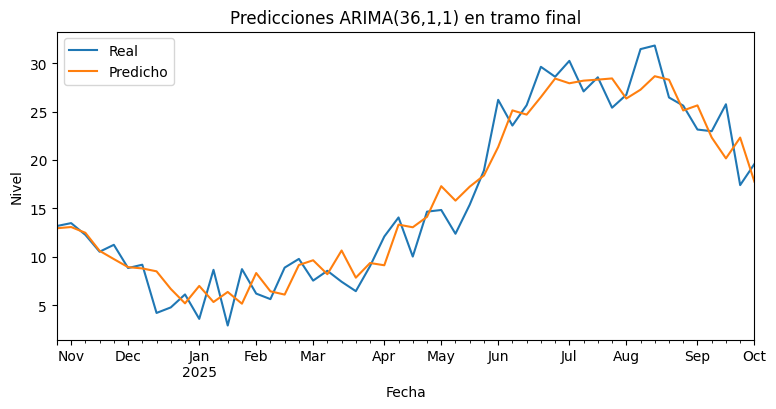

In [ ]:
# ARIMA(36,1,1) sobre la serie original
modelo_arima = ARIMA(y, order=(36,1,1))
res_arima = modelo_arima.fit()
print(res_arima.summary())

# Predicción del mismo tramo final (reentrenando completo)
pred_arima = res_arima.predict(start=len(y)-HORIZON, end=len(y)-1, typ="levels")

MAE_arima = mae(y_valid, pred_arima)
RMSE_arima = rmse(y_valid, pred_arima)
print(f"[ARIMA(36,1,1)] MAE={MAE_arima:.3f}  RMSE={RMSE_arima:.3f}")

plt.figure()
y_valid.plot(label="Real", title="Predicciones ARIMA(36,1,1) en tramo final")
pred_arima.plot(label="Predicho")
plt.xlabel("Fecha"); plt.ylabel("Nivel"); plt.legend()
plt.show()

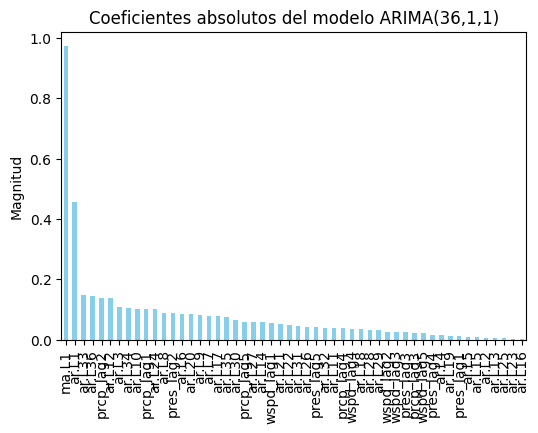

In [ ]:
#importancia de las variables
coefs = res_arima.params.drop('sigma2', errors='ignore')
plt.figure(figsize=(6,4))
coefs.abs().sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Coeficientes absolutos del modelo ARIMA(36,1,1)")
plt.ylabel("Magnitud")
plt.show()


### Modelo con variables exógenas (ARIMAX)

                               SARIMAX Results                                
Dep. Variable:                   tavg   No. Observations:                  400
Model:                ARIMA(36, 1, 1)   Log Likelihood                -869.777
Date:                Thu, 23 Oct 2025   AIC                           1845.554
Time:                        16:05:00   BIC                           2056.969
Sample:                    02-11-2018   HQIC                          1929.285
                         - 10-05-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
prcp_lag1     -0.1014      0.063     -1.601      0.109      -0.226       0.023
wspd_lag1     -0.0543      0.064     -0.849      0.396      -0.180       0.071
pres_lag1      0.0122      0.044      0.277      0.7

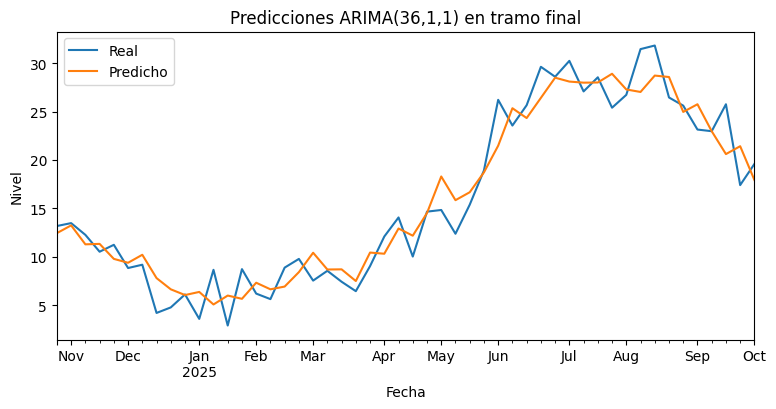

In [ ]:
# ARIMA(36,1,1) sobre la serie original
modelo_arima = ARIMA(y, exog=exog_lags.astype(float), order=(36,1,1))
res_arima = modelo_arima.fit()
print(res_arima.summary())

# Predicción del mismo tramo final (reentrenando completo)
pred_arima = res_arima.predict(start=len(y)-HORIZON, end=len(y)-1, typ="levels")

MAE_arima = mae(y_valid, pred_arima)
RMSE_arima = rmse(y_valid, pred_arima)
print(f"[ARIMA(36,1,1)] MAE={MAE_arima:.3f}  RMSE={RMSE_arima:.3f}")

plt.figure()
y_valid.plot(label="Real", title="Predicciones ARIMA(36,1,1) en tramo final")
pred_arima.plot(label="Predicho")
plt.xlabel("Fecha"); plt.ylabel("Nivel"); plt.legend()
plt.show()

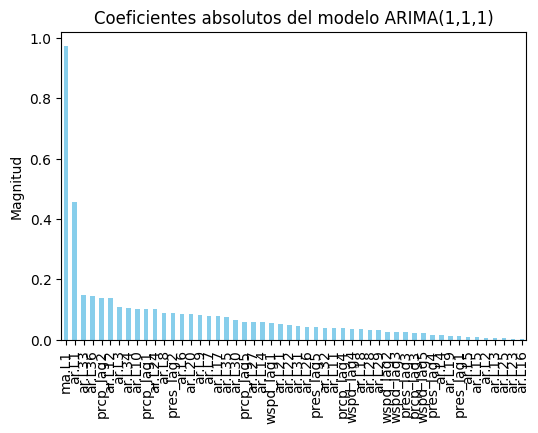

In [ ]:
coefs = res_arima.params.drop('sigma2', errors='ignore')
plt.figure(figsize=(6,4))
coefs.abs().sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Coeficientes absolutos del modelo ARIMA(36,1,1)")
plt.ylabel("Magnitud")
plt.show()



## Modelo SARIMAX

### Modelo sin variables exógenas

                                      SARIMAX Results                                      
Dep. Variable:                                tavg   No. Observations:                  400
Model:             SARIMAX(36, 1, 1)x(1, 0, 1, 52)   Log Likelihood                -685.569
Date:                             Thu, 23 Oct 2025   AIC                           1451.137
Time:                                     16:11:07   BIC                           1600.729
Sample:                                 02-11-2018   HQIC                          1510.931
                                      - 10-05-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4331      0.055      7.901      0.000       0.326       0.541
ar.L2          0.0292      

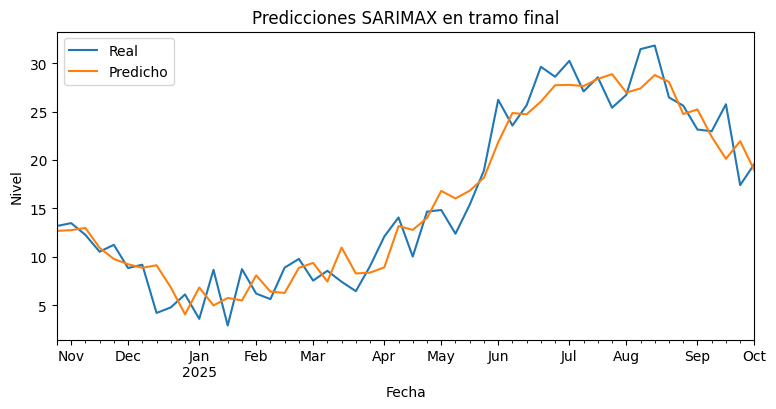

In [ ]:
# Modelo con estacionalidad anual aproximada (52 semanas)
modelo_sarimax = SARIMAX(y, order=(36,1,1), seasonal_order=(1,0,1,52), enforce_stationarity=False, enforce_invertibility=False)
res_sarimax = modelo_sarimax.fit(disp=False)
print(res_sarimax.summary())

pred_sarimax = res_sarimax.predict(start=len(y)-HORIZON, end=len(y)-1, dynamic=False)

MAE_sarimax = mae(y_valid, pred_sarimax)
RMSE_sarimax = rmse(y_valid, pred_sarimax)
print(f"[SARIMAX(36,1,1)(1,0,1,52)] MAE={MAE_sarimax:.3f}  RMSE={RMSE_sarimax:.3f}")

plt.figure()
y_valid.plot(label="Real", title="Predicciones SARIMAX en tramo final")
pred_sarimax.plot(label="Predicho")
plt.xlabel("Fecha"); plt.ylabel("Nivel"); plt.legend()
plt.show()

### Modelo con variables exógenas

                                      SARIMAX Results                                      
Dep. Variable:                                tavg   No. Observations:                  400
Model:             SARIMAX(36, 1, 1)x(1, 0, 1, 52)   Log Likelihood                -673.738
Date:                             Thu, 23 Oct 2025   AIC                           1457.475
Time:                                     16:16:45   BIC                           1663.164
Sample:                                 02-11-2018   HQIC                          1539.692
                                      - 10-05-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
prcp_lag1     -0.0836      0.066     -1.266      0.205      -0.213       0.046
wspd_lag1     -0.0747      

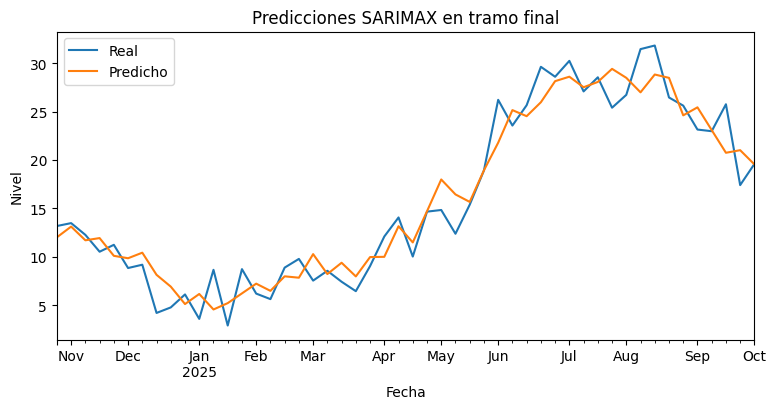

In [ ]:
# Modelo con estacionalidad anual aproximada (52 semanas)
modelo_sarimax_ex = SARIMAX(y,exog=exog_lags.astype(float), order=(36,1,1), seasonal_order=(1,0,1,52), enforce_stationarity=False, enforce_invertibility=False)
res_sarimax = modelo_sarimax_ex.fit(disp=False)
print(res_sarimax.summary())

pred_sarimax = res_sarimax.predict(start=len(y)-HORIZON, end=len(y)-1, dynamic=False)

MAE_sarimax = mae(y_valid, pred_sarimax)
RMSE_sarimax = rmse(y_valid, pred_sarimax)
print(f"[SARIMAX(1,1,1)(1,0,1,52)] MAE={MAE_sarimax:.3f}  RMSE={RMSE_sarimax:.3f}")

plt.figure()
y_valid.plot(label="Real", title="Predicciones SARIMAX en tramo final")
pred_sarimax.plot(label="Predicho")
plt.xlabel("Fecha"); plt.ylabel("Nivel"); plt.legend()
plt.show()


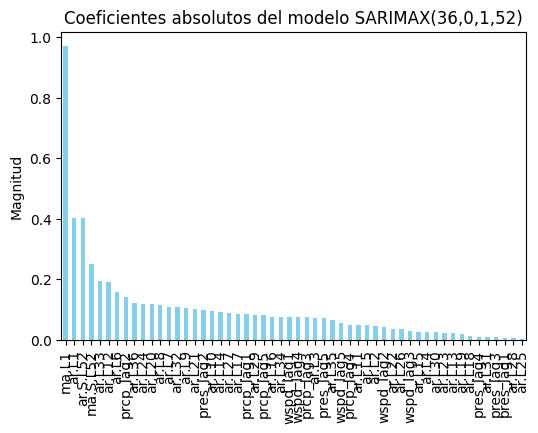

In [ ]:
coefs = res_sarimax.params.drop('sigma2', errors='ignore')
plt.figure(figsize=(6,4))
coefs.abs().sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Coeficientes absolutos del modelo SARIMAX(36,0,1,52)")
plt.ylabel("Magnitud")
plt.show()

## Modelos de ML: GridSearchCV y backtesting

In [ ]:
freq = pd.infer_freq(y.index)

# Reasignar frecuencia explícita si la conocemos
if freq is not None:
    y_train.index = pd.DatetimeIndex(y_train.index, freq=freq)
    y_valid.index = pd.DatetimeIndex(y_valid.index, freq=freq)
else:
    print('⚠️ Serie sin frecuencia inferible. Puedes usar ignore_freq=True en fit/backtesting.')

print(f'Freq: {freq}')
print(f'Train: {y_train.index[0].date()} → {y_train.index[-1].date()} (n={len(y_train)})')
print(f'Valid: {y_valid.index[0].date()} → {y_valid.index[-1].date()} (n={len(y_valid)})')

# se implementa validación cruzada respetando el orden temporal
cv = TimeSeriesFold(
    steps=H,
    initial_train_size=len(y) - H,
    fixed_train_size=True
)
cv

Freq: W-SUN
Train: 2018-01-07 → 2024-10-20 (n=355)
Valid: 2024-10-27 → 2025-10-05 (n=50)


============== 
TimeSeriesFold 
============== 
Initial train size    = 350,
Steps                 = 50,
Fold stride           = 50,
Overlapping folds     = False,
Window size           = None,
Differentiation       = None,
Refit                 = False,
Fixed train size      = True,
Gap                   = 0,
Skip folds            = None,
Allow incomplete fold = True,
Return all indexes    = False,
Verbose               = True

In [ ]:
# Helpers robustos para grid-search y backtesting
def tune_model(y, regressor, param_grid, lags_grid, cv, metric='mean_absolute_error', ignore_freq=None):
    """
    Ejecuta grid_search_forecaster() y devuelve SIEMPRE:
      - results_df: DataFrame con combinaciones evaluadas
      - f_best: ForecasterRecursive ajustado con la mejor configuración
    Compatible con variantes que devuelven dict o DataFrame.
    """
    f = ForecasterRecursive(regressor=regressor, lags=lags_grid[0] if len(lags_grid) else 12)
    kwargs = dict(
        forecaster=f, y=y, cv=cv, lags_grid=lags_grid, param_grid=param_grid,
        metric=metric, return_best=True, verbose=False
    )
    if ignore_freq:
        kwargs['ignore_freq'] = True

    out = grid_search_forecaster(**kwargs)

    if isinstance(out, dict) and 'results' in out and 'forecaster' in out:
        results_df, f_best = out['results'], out['forecaster']
    else:
        results_df, f_best = out, f

    return results_df, f_best


def backtest_best(f_best, y, cv, metric='mean_absolute_error', ignore_freq=None):
    """
    Devuelve:
      - metrics_out: métricas por split (tipo varía por versión)
      - preds_out: DF de predicciones o None
    Soporta API con/sin 'return_predict'.
    """
    kwargs = dict(forecaster=f_best, y=y, cv=cv, metric=metric, verbose=False)
    if ignore_freq:
        kwargs['ignore_freq'] = True

    try:
        metrics_out, preds_out = backtesting_forecaster(return_predict=True, **kwargs)
    except TypeError:
        out = backtesting_forecaster(**kwargs)
        if isinstance(out, tuple) and len(out) == 2:
            metrics_out, preds_out = out
        else:
            metrics_out, preds_out = out, None
    return metrics_out, preds_out



def extract_mae(metrics_out, metric_name='mean_absolute_error'):
    """Extrae MAE medio de la salida de métricas, sea float/Series/DataFrame."""
    import numpy as _np
    import pandas as _pd

    if isinstance(metrics_out, (float, int, _np.floating, _np.integer)):
        return float(metrics_out)

    if isinstance(metrics_out, _pd.Series):
        return float(_pd.to_numeric(metrics_out, errors='coerce').mean())

    if isinstance(metrics_out, _pd.DataFrame):
        df = metrics_out.copy()
        if {'metric','value'}.issubset(df.columns):
            mask = (df['metric'] == metric_name)
            if mask.any():
                return float(_pd.to_numeric(df.loc[mask, 'value'], errors='coerce').mean())
            return float(_pd.to_numeric(df['value'], errors='coerce').mean())
        num = df.select_dtypes(include=_np.number)
        if not num.empty:
            return float(num.iloc[:, 0].mean())
    raise ValueError('Formato de métricas no reconocido para extraer MAE.')

In [ ]:
#Modelos base
ridge = Ridge(random_state=0)
lasso = Lasso(random_state=0)
enet  = ElasticNet(random_state=0)
tree  = DecisionTreeRegressor(random_state=0)
rf    = RandomForestRegressor(random_state=0, n_jobs=-1)
gbr   = GradientBoostingRegressor(random_state=0)
knn   = KNeighborsRegressor()
svr   = SVR()

# Rejillas de hiperparámetros
lags_grid = [12, 24, 36, 52]

param_grid_ridge = {'alpha': [0.1, 1.0, 10.0]}
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1.0]}
param_grid_enet  = {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.2, 0.5, 0.8]}
param_grid_tree  = {'max_depth': [3, 5, 8, None]}
param_grid_rf    = {'n_estimators': [200, 400], 'max_depth': [5, 10, None]}
param_grid_gbr   = {'n_estimators': [200, 400], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
param_grid_knn   = {'n_neighbors': [3, 5, 10, 20], 'weights': ['uniform', 'distance']}
param_grid_svr   = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1.0, 10.0], 'epsilon': [0.01, 0.1]}


print('🔎 Tuning Ridge...')
ridge_results, f_ridge_best = tune_model(y, ridge, param_grid_ridge, lags_grid, cv)

print('🔎 Tuning Lasso...')
lasso_results, f_lasso_best = tune_model(y, lasso, param_grid_lasso, lags_grid, cv)

print('🔎 Tuning Elastic Net...')
enet_results, f_enet_best = tune_model(y, enet, param_grid_enet, lags_grid, cv)

print('🔎 Tuning Decision Tree...')
tree_results, f_tree_best = tune_model(y, tree, param_grid_tree, lags_grid, cv)

print('🔎 Tuning Random Forest...')
rf_results, f_rf_best = tune_model(y, rf, param_grid_rf, lags_grid, cv)

print('🔎 Tuning Gradient Boosting...')
gbr_results, f_gbr_best = tune_model(y, gbr, param_grid_gbr, lags_grid, cv)

print('🔎 Tuning KNN...')
knn_results, f_knn_best = tune_model(y, knn, param_grid_knn, lags_grid, cv)

print('🔎 Tuning SVR...')
svr_results, f_svr_best = tune_model(y, svr, param_grid_svr, lags_grid, cv)

ridge_results.head()


🔎 Tuning Ridge...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52] 
  Parameters: {'alpha': 10.0}
  Backtesting metric: 2.12909176242678
🔎 Tuning Lasso...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52] 
  Parameters: {'alpha': 0.1}
  Backtesting metric: 2.10212092847706
🔎 Tuning Elastic Net...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52] 
  Parameters: {'alpha': 1.0, 'l1_ratio': 0.5}
  Backtesting metric: 2.0891808157932776
🔎 Tuning Decision Tree...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52] 
  Parameters: {'max_depth': None}
  Backtesting metric: 2.462785714285714
🔎 Tuning Random Forest...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': None, 'n_estimators': 400}
  Backtesting metric: 2.129216547619048
🔎 Tuning Gradient Boosting...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/8 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}
  Backtesting metric: 2.1379992223278443
🔎 Tuning KNN...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/8 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52] 
  Parameters: {'n_neighbors': 20, 'weights': 'uniform'}
  Backtesting metric: 2.09782380952381
🔎 Tuning SVR...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'C': 1.0, 'epsilon': 0.1, 'kernel': 'rbf'}
  Backtesting metric: 2.0073915512150795


,lags,lags_label,params,mean_absolute_error,alpha
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 10.0},2.1291,10.0000
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1.0},2.1301,1.0000
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},2.1302,0.1000
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},2.1314,0.1000
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1.0},2.1315,1.0000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Comparación de modelos (promedio CV):


,modelo,mae_cv
0,SVR,2.0074
1,ElasticNet,2.0892
2,KNN,2.0978
3,Lasso,2.1021
4,Ridge,2.1291
5,RandomForest,2.1292
6,GradientBoosting,2.1380
7,DecisionTree,2.4628


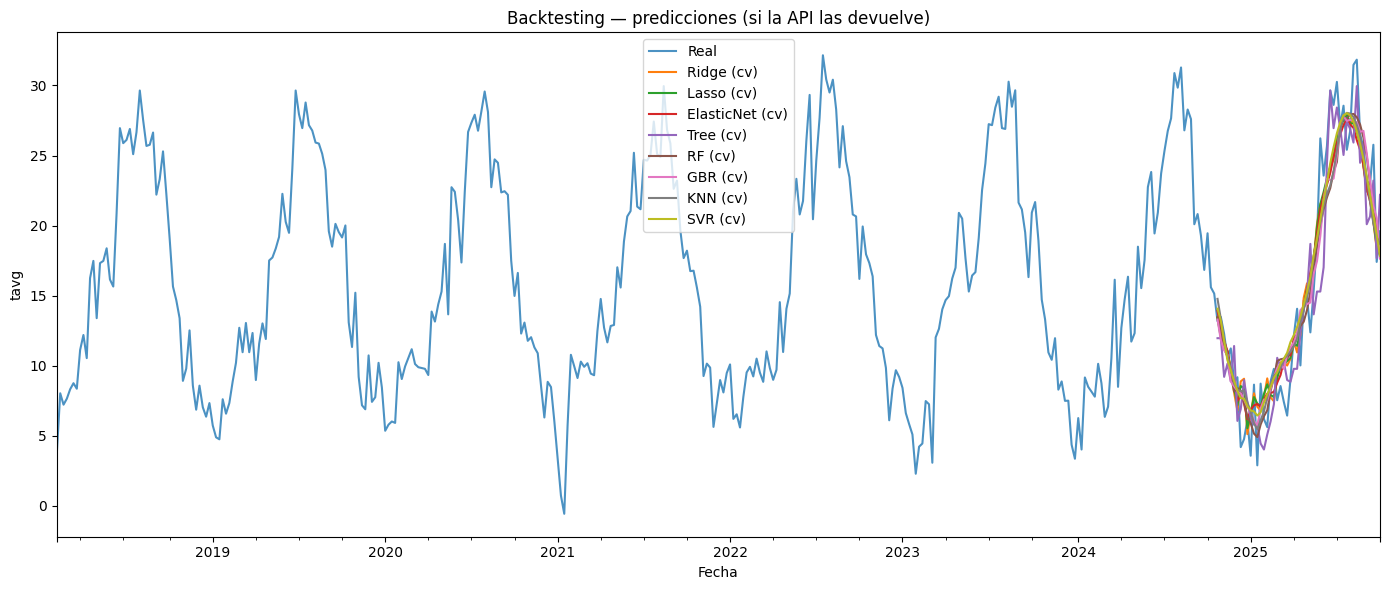

In [ ]:
# Backtesting con los mejores modelos

# ejecución backtesting para cada uno
m_ridge, p_ridge = backtest_best(f_ridge_best, y, cv)
m_lasso, p_lasso = backtest_best(f_lasso_best, y, cv)
m_enet,  p_enet  = backtest_best(f_enet_best,  y, cv)
m_tree,  p_tree  = backtest_best(f_tree_best,  y, cv)
m_rf,    p_rf    = backtest_best(f_rf_best,    y, cv)
m_gbr,   p_gbr   = backtest_best(f_gbr_best,   y, cv)
m_knn,   p_knn   = backtest_best(f_knn_best,   y, cv)
m_svr,   p_svr   = backtest_best(f_svr_best,   y, cv)

# Comparación de desempeño (RMSE + MAE)
compare = pd.DataFrame({
    'modelo': [
        'Ridge', 'Lasso', 'ElasticNet', 'DecisionTree',
        'RandomForest', 'GradientBoosting', 'KNN', 'SVR'
    ],
    'mae_cv': [
        extract_mae(m_ridge, 'mean_absolute_error'),
        extract_mae(m_lasso, 'mean_absolute_error'),
        extract_mae(m_enet,  'mean_absolute_error'),
        extract_mae(m_tree,  'mean_absolute_error'),
        extract_mae(m_rf,    'mean_absolute_error'),
        extract_mae(m_gbr,   'mean_absolute_error'),
        extract_mae(m_knn,   'mean_absolute_error'),
        extract_mae(m_svr,   'mean_absolute_error'),
    ]
})

# Orden por RMSE (menor es mejor)
compare = compare.sort_values('mae_cv').reset_index(drop=True)

print('Comparación de modelos (promedio CV):')
display(compare)

# predicciones
def plot_cv_preds(preds, label):
    if preds is None or not isinstance(preds, pd.DataFrame):
        return False
    for col in ['pred', 'prediction', 'y_pred', 'forecast']:
        if col in preds.columns:
            preds[col].plot(label=label)
            return True
    return False

plt.figure(figsize=(14, 6))
y.plot(label='Real', alpha=0.8)

ok = False
ok |= plot_cv_preds(p_ridge, 'Ridge (cv)')
ok |= plot_cv_preds(p_lasso, 'Lasso (cv)')
ok |= plot_cv_preds(p_enet,  'ElasticNet (cv)')
ok |= plot_cv_preds(p_tree,  'Tree (cv)')
ok |= plot_cv_preds(p_rf,    'RF (cv)')
ok |= plot_cv_preds(p_gbr,   'GBR (cv)')
ok |= plot_cv_preds(p_knn,   'KNN (cv)')
ok |= plot_cv_preds(p_svr,   'SVR (cv)')

plt.title('Backtesting — predicciones (si la API las devuelve)' if ok else
          'Backtesting — la API no devolvió predicciones (solo valores reales)')
plt.xlabel('Fecha')
plt.ylabel('tavg')
plt.legend()
plt.tight_layout()
plt.show()


## Mejor modelo de ML sin exógenas

[BASE sin exógenas] lags=36  MAE=2.006  RMSE=2.543


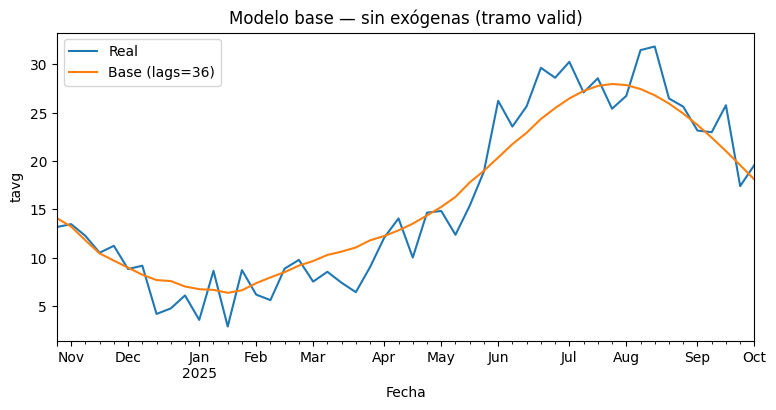

In [ ]:
# Se implementará un modelo SVR sin variables exógenas, únicamente con los lags especificados
lags_base = 36
forecaster_base = ForecasterRecursive(regressor=SVR(C= 1.0, epsilon= 0.01, kernel= 'rbf'), lags=lags_base)
forecaster_base.fit(y=y_train)

# Se hace la predicción para la ventana de tiempo especificada
pred_base = forecaster_base.predict(steps=len(y_valid))

# Métricas
MAE_base = mean_absolute_error(y_valid, pred_base)
RMSE_base = mean_squared_error(y_valid, pred_base) ** 0.5

print(f"[BASE sin exógenas] lags={lags_base}  MAE={MAE_base:.3f}  RMSE={RMSE_base:.3f}")

plt.figure()
y_valid.plot(label='Real')
pred_base.plot(label=f'Base (lags={lags_base})')
plt.title('Modelo base — sin exógenas (tramo valid)')
plt.xlabel('Fecha'); plt.ylabel('tavg')
plt.legend(); plt.show()

# Modelos de ML con variables exógenas

In [ ]:
#modelos
models = {
    'Ridge': {
        'regressor': Ridge(random_state=0),
        'param_grid': {'alpha': [0.1, 1.0, 10.0]}
    },
    'Lasso': {
        'regressor': Lasso(random_state=0, max_iter=5000),
        'param_grid': {'alpha': [0.001, 0.01, 0.1, 1.0]}
    },
    'ElasticNet': {
        'regressor': ElasticNet(random_state=0, max_iter=5000),
        'param_grid': {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.2, 0.5, 0.8]}
    },
    'DecisionTree': {
        'regressor': DecisionTreeRegressor(random_state=0),
        'param_grid': {'max_depth': [3, 5, 8, None]}
    },
    'RandomForest': {
        'regressor': RandomForestRegressor(random_state=0, n_jobs=-1),
        'param_grid': {'n_estimators': [200, 400], 'max_depth': [5, 10, None]}
    },
    'GradientBoosting': {
        'regressor': GradientBoostingRegressor(random_state=0),
        'param_grid': {'n_estimators': [200, 400], 'learning_rate': [0.05, 0.1]}
    },
    'KNN': {
        'regressor': KNeighborsRegressor(),
        'param_grid': {'n_neighbors': [3, 5, 8], 'weights': ['uniform', 'distance']}
    },
    'SVR': {
        'regressor': SVR(),
        'param_grid': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    }
}

lags_grid = [12, 24, 36, 52]

# Variables exógenas
#exog = df_week_mean.drop(columns=['tavg'])

#loop de turning con exógenas
best_models = {}
results_all = {}

for name, cfg in models.items():
    print(f'🔎 Tuning {name}...')
    reg = cfg['regressor']
    param_grid = cfg['param_grid']

    f = ForecasterRecursive(regressor=reg, lags=lags_grid[0])

    #grid search con exógenas
    kwargs = dict(
        forecaster=f,
        y=y,
        exog=exog_lags,
        cv=cv,
        lags_grid=lags_grid,
        param_grid=param_grid,
        metric='mean_absolute_error',
        return_best=True,
        verbose=False
    )

    out = grid_search_forecaster(**kwargs)

    if isinstance(out, dict) and 'results' in out and 'forecaster' in out:
        results_df, f_best = out['results'], out['forecaster']
    else:
        results_df, f_best = out, f

    results_all[name] = results_df
    best_models[name] = f_best

print("✅ Tuning completado.")


🔎 Tuning Ridge...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'alpha': 10.0}
  Backtesting metric: 2.0664548682437696
🔎 Tuning Lasso...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'alpha': 0.1}
  Backtesting metric: 1.990174340682453
🔎 Tuning ElasticNet...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52] 
  Parameters: {'alpha': 1.0, 'l1_ratio': 0.2}
  Backtesting metric: 1.9727739820172
🔎 Tuning DecisionTree...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'max_depth': 5}
  Backtesting metric: 2.4201952678200476
🔎 Tuning RandomForest...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'max_depth': 10, 'n_estimators': 400}
  Backtesting metric: 1.9947530292843783
🔎 Tuning GradientBoosting...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'learning_rate': 0.05, 'n_estimators': 200}
  Backtesting metric: 2.288959957647499
🔎 Tuning KNN...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52] 
  Parameters: {'n_neighbors': 3, 'weights': 'distance'}
  Backtesting metric: 2.0470272548887376
🔎 Tuning SVR...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'C': 0.1, 'kernel': 'linear'}
  Backtesting metric: 1.8940843980092765
✅ Tuning completado.


📈 Backtesting Ridge...


  0%|          | 0/1 [00:00<?, ?it/s]

📈 Backtesting Lasso...


  0%|          | 0/1 [00:00<?, ?it/s]

📈 Backtesting ElasticNet...


  0%|          | 0/1 [00:00<?, ?it/s]

📈 Backtesting DecisionTree...


  0%|          | 0/1 [00:00<?, ?it/s]

📈 Backtesting RandomForest...


  0%|          | 0/1 [00:00<?, ?it/s]

📈 Backtesting GradientBoosting...


  0%|          | 0/1 [00:00<?, ?it/s]

📈 Backtesting KNN...


  0%|          | 0/1 [00:00<?, ?it/s]

📈 Backtesting SVR...


  0%|          | 0/1 [00:00<?, ?it/s]

Comparación final (MAE):


,modelo,mae_cv
0,ElasticNet,2.0912
1,Ridge,2.1322
2,RandomForest,2.1399
3,Lasso,2.1413
4,SVR,2.1806
5,GradientBoosting,2.1981
6,KNN,2.3668
7,DecisionTree,2.4650


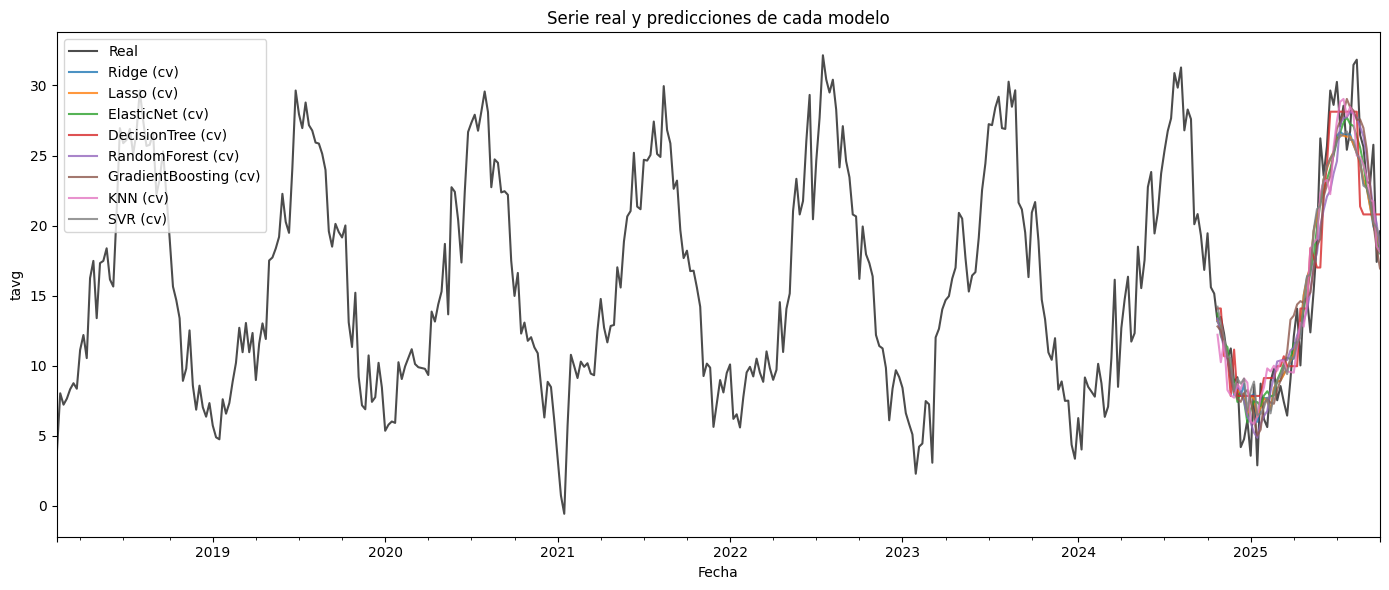

In [ ]:

# Backtesting y creación de best_preds (solo MAE)
best_preds = []
compare = []

for name, f_best in best_models.items():
    print(f'📈 Backtesting {name}...')

    metrics, preds = backtest_best(f_best, y, cv)

    best_preds.append((name, preds))

    mae  = extract_mae(metrics, 'mean_absolute_error')

    compare.append({'modelo': name, 'mae_cv': mae})

# Diccionarios finales
best_preds = dict(best_preds)
compare = pd.DataFrame(compare).sort_values('mae_cv').reset_index(drop=True)

print("Comparación final (MAE):")
display(compare)

#graficas y predicciones
plt.figure(figsize=(14,6))
y.plot(label='Real', color='black', alpha=0.7)

def plot_preds(preds, label):
    if preds is None or not isinstance(preds, pd.DataFrame):
        return False
    for col in ['pred','prediction','y_pred','forecast']:
        if col in preds.columns:
            preds[col].plot(label=label, alpha=0.8)
            return True
    return False

ok = False
for name, preds in best_preds.items():
    ok |= plot_preds(preds, f'{name} (cv)')

plt.title('Serie real y predicciones de cada modelo')
plt.xlabel('Fecha')
plt.ylabel('tavg')
plt.legend()
plt.tight_layout()
plt.show()


# Predicciones 2025-2030
Para predecir la temperatura desde el 30/09/2025 hasta el 30/09/2030 se implementa el modelo SARIMAX con variables exógenas, que fue el que mostró mejores resultados entre los modelos evaluados.

## Modelos autorregresivos

### ARIMA

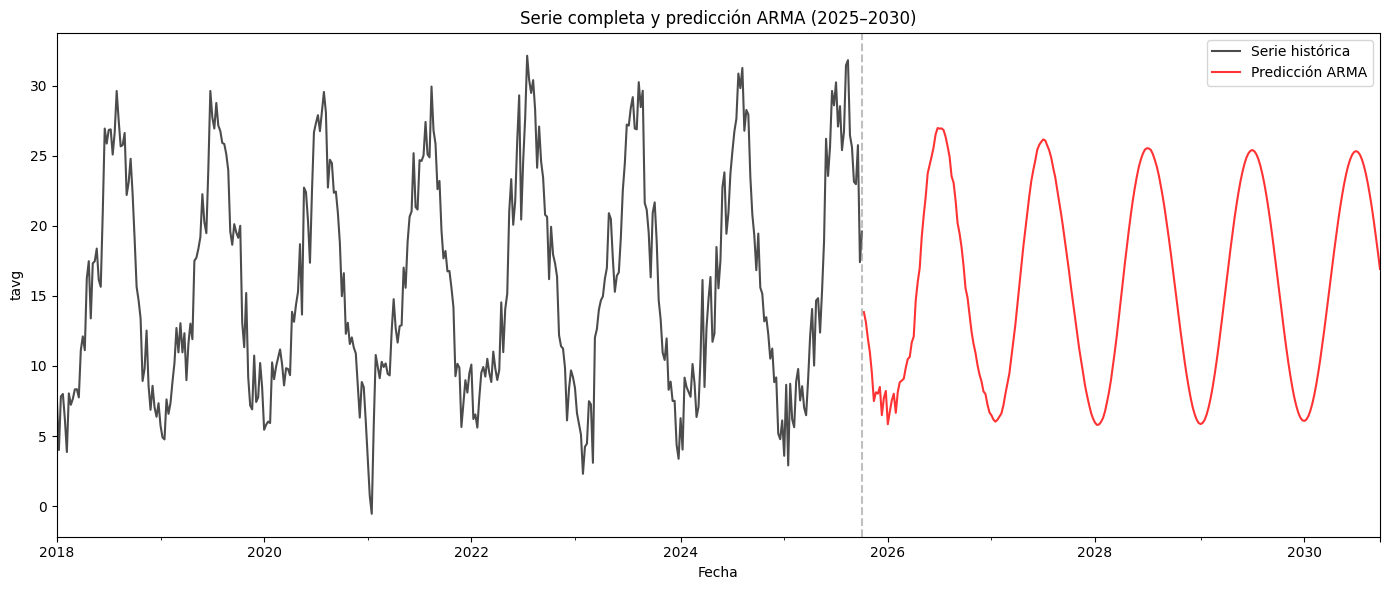

In [ ]:
# modelo ARMA (sin diferencia)
# order=(p, d, q) → d=0 porque no hay diferenciación
modelo_arma = ARIMA(y_train, order=(36, 1, 1))
res_arma = modelo_arma.fit()

# Predicciones en el tramo de validación
start = y_valid.index[0]
end = y_valid.index[-1]
pred_arma = res_arma.predict(start=start, end=end)

# horizonte de predicción
start_pred = pd.to_datetime("2025-09-30")
end_pred   = pd.to_datetime("2030-09-30")
future_index = pd.date_range(start=start_pred + pd.Timedelta(weeks=1),
                             end=end_pred, freq='W')  # semanal

# generar predicciones dinámicas para el futuro
pred_future = res_arma.get_forecast(steps=len(future_index)).predicted_mean
pred_future.index = future_index

plt.figure(figsize=(14,6))
y.plot(label="Serie histórica", color='black', alpha=0.7)
pred_future.plot(label="Predicción ARMA", color='red', alpha=0.8)

plt.axvline(start_pred, color='gray', linestyle='--', alpha=0.5)
plt.title("Serie completa y predicción ARMA (2025–2030)")
plt.xlabel("Fecha")
plt.ylabel("tavg")
plt.legend()
plt.tight_layout()
plt.show()


### SARIMAX

In [ ]:
len(exog_lags)

400

In [ ]:
len(y)

405

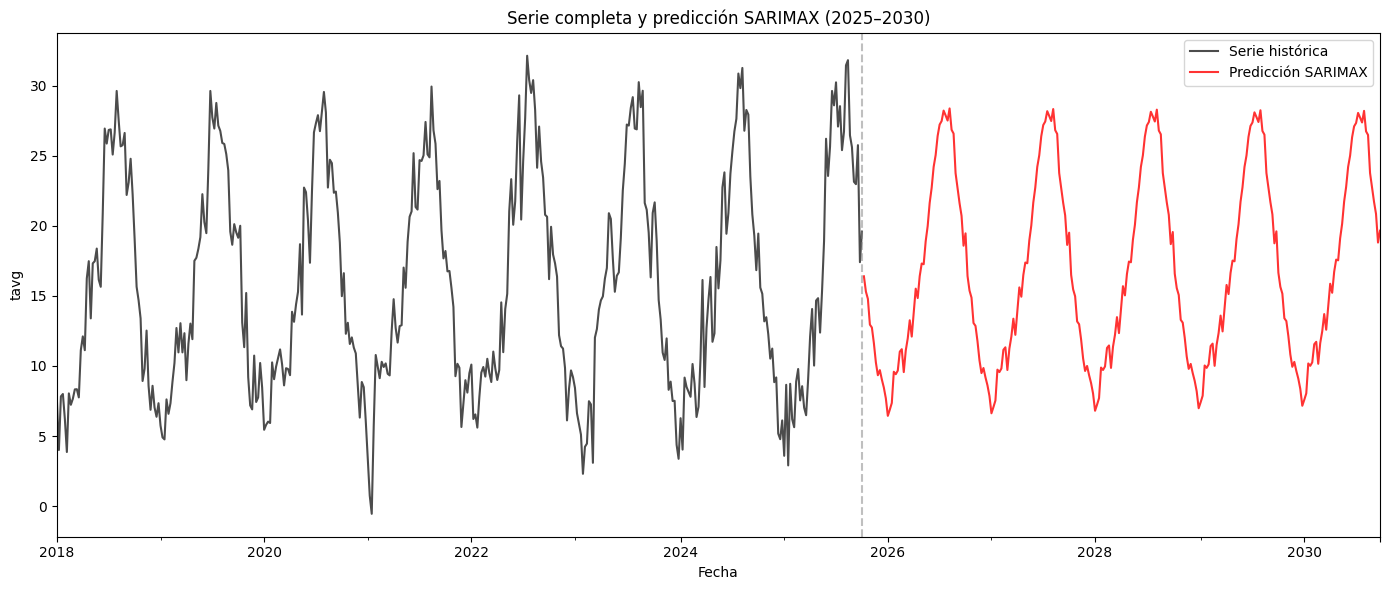

In [ ]:
# modelo SARIMAX
modelo_sarimax_ex = SARIMAX(
    y.iloc[5:],
    exog=exog_lags.astype(float),
    order=(1,1,1),
    seasonal_order=(1,0,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res_sarimax = modelo_sarimax_ex.fit(disp=False)

# horizonte de predicción
start_pred = pd.to_datetime("2025-09-30")
end_pred   = pd.to_datetime("2030-09-30")
future_index = pd.date_range(start=start_pred + pd.Timedelta(weeks=1),
                             end=end_pred, freq='W')  # semanal

# Crear exógenas futuras (constantes con último valor observado)
exog_future = pd.DataFrame(
    [exog_lags.iloc[-1].values] * len(future_index),
    index=future_index,
    columns=exog_lags.columns
)

# Generar predicciones dinámicas para el futuro
pred_future = res_sarimax.get_forecast(steps=len(future_index), exog=exog_future).predicted_mean
pred_future.index = future_index

plt.figure(figsize=(14,6))
y.plot(label="Serie histórica", color='black', alpha=0.7)
pred_future.plot(label="Predicción SARIMAX", color='red', alpha=0.8)

plt.axvline(start_pred, color='gray', linestyle='--', alpha=0.5)
plt.title("Serie completa y predicción SARIMAX (2025–2030)")
plt.xlabel("Fecha")
plt.ylabel("tavg")
plt.legend()
plt.tight_layout()
plt.show()


## SVR

In [ ]:
lags_opt = 36
regressor_opt = SVR(C=1, kernel='rbf',epsilon=0.1)
forecaster_svr = ForecasterRecursive(
    regressor=regressor_opt,
    lags=lags_opt
)

# ajuste del modelo
forecaster_svr.fit(
    y=y_train
)

# predicción
pred_svr = forecaster_svr.predict(
    steps=len(y_valid)
)

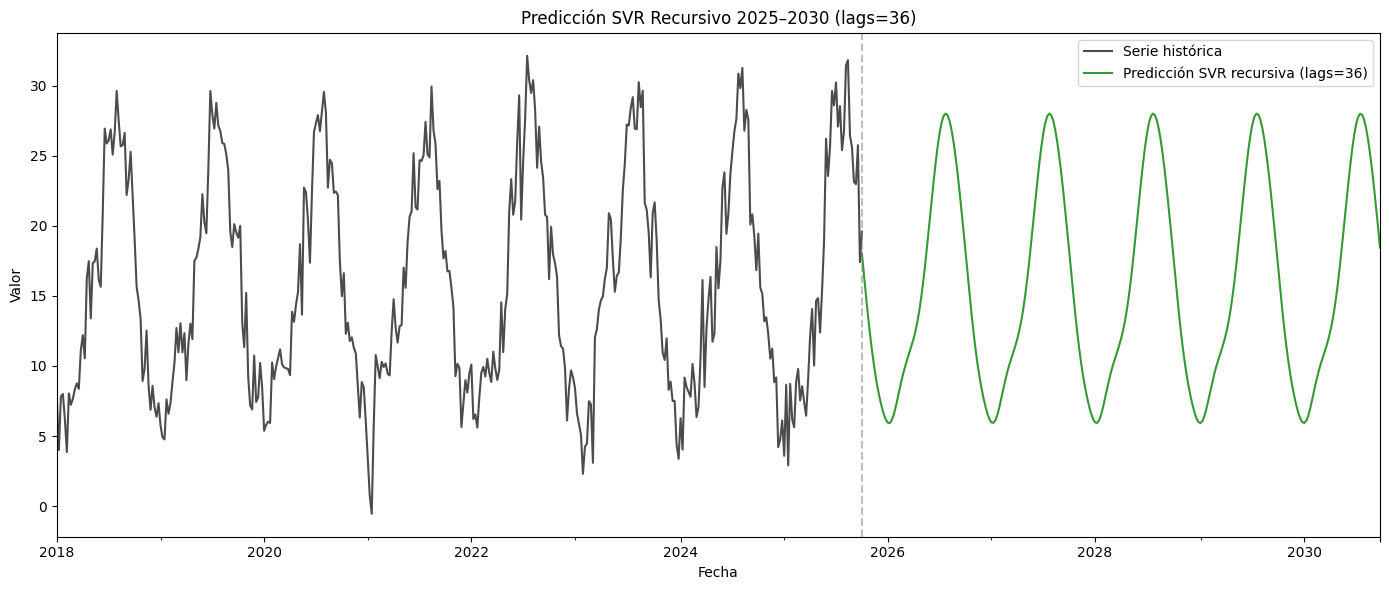

In [ ]:
lags_base = 36

y_train_forecast = y.loc[:'2025-09-30']  # entrenamiento hasta el 30/09/2025
forecaster_svr.fit(
    y=y_train
)

# índice de fechas futuras
start_pred = pd.to_datetime("2025-09-30")
end_pred   = pd.to_datetime("2030-09-30")
future_index = pd.date_range(
    start=start_pred + pd.Timedelta(weeks=1),
    end=end_pred,
    freq='W'
)

#Última fecha usada en entrenamiento
last_train_date = y_train.iloc[5:].index[-1]

# Crear índice futuro a partir de la semana siguiente
future_index = pd.date_range(
    start=last_train_date + pd.Timedelta(weeks=1),
    end=end_pred,
    freq='W'
)


pred_future = forecaster_svr.predict(
    steps=len(future_index)
)
pred_future.index = future_index

plt.figure(figsize=(14,6))
y.plot(label="Serie histórica", color='black', alpha=0.7)
pred_future.loc['2025-09-30':].plot(label=f"Predicción SVR recursiva (lags={lags_base})", color='green', alpha=0.8)
plt.axvline(start_pred, color='gray', linestyle='--', alpha=0.5)
plt.title(f"Predicción SVR Recursivo 2025–2030 (lags={lags_base})")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.tight_layout()
plt.show()
